In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import rqfactor
import talib
from rqalpha.apis import *
from rqfactor.notebook.exposure import factor_analysis
from rqoptimizer import *
from rqoptimizer.utils import *
from rqdatac import *
from rqalpha_plus import run_func
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from functools import wraps
warnings.filterwarnings("ignore")
rqdatac.init()

Cannot initialize filter sz3: File not found


In [2]:
df_etf = pd.read_excel('../../ETF0-ML/etf标的.xlsx')
etf_code = df_etf.code.values.tolist()
etf_code = [str(code) for code in etf_code]
df_etf = all_instruments(type='ETF' , market = 'cn')
df_etf = df_etf[df_etf.trading_code.isin(etf_code)]

In [3]:
symbol = df_etf.order_book_id.values.tolist()
start = "2014-01-01"
end = "2024-03-31"
frequency = "60m"
df1 = get_price(symbol, start, end, frequency)[['open','high','low','close']]
df1.head()

open   high    low  close
order_book_id datetime                                       
159507.XSHE   2023-06-21 10:30:00  1.058  1.060  1.010  1.029
              2023-06-21 11:30:00  1.028  1.031  1.025  1.029
              2023-06-21 14:00:00  1.027  1.030  1.027  1.028
              2023-06-21 15:00:00  1.028  1.028  1.019  1.024
              2023-06-26 10:30:00  1.009  1.020  0.999  1.000

In [4]:
df_price = get_price(symbol, start, end, frequency)[['close']].unstack(level = 0)
df_price.columns = df_price.columns.droplevel(0)
df_price.head()

order_book_id,159507.XSHE,159611.XSHE,159619.XSHE,159766.XSHE,159825.XSHE,159852.XSHE,159869.XSHE,159870.XSHE,159928.XSHE,159930.XSHE,...,512660.XSHG,512800.XSHG,512880.XSHG,512980.XSHG,513050.XSHG,515030.XSHG,515790.XSHG,515880.XSHG,516110.XSHG,561320.XSHG
datetime,,,,,,,,,,,,,,,,,,,,,
2014-01-02 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2448,0.878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2450,0.877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2452,0.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2455,0.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2432,0.869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2014-03-21 14:00:00: 买入 159928.XSHE, 价格 0.2362, 数量 10584
2014-03-31 10:30:00: 卖出 159928.XSHE, 价格 0.2288, 数量 10584
2014-04-08 10:30:00: 买入 159928.XSHE, 价格 0.2358, 数量 10519
2014-04-14 15:00:00: 买入 159930.XSHE, 价格 0.811, 数量 3058
2014-04-23 10:30:00: 卖出 159930.XSHE, 价格 0.79, 数量 3058
2014-04-25 10:30:00: 卖出 159928.XSHE, 价格 0.2355, 数量 10519
2014-05-22 10:30:00: 买入 159930.XSHE, 价格 0.788, 数量 3126
2014-06-03 10:30:00: 卖出 159930.XSHE, 价格 0.782, 数量 3126
2014-06-11 15:00:00: 买入 512010.XSHG, 价格 0.2125, 数量 11571
2014-06-13 14:00:00: 买入 159930.XSHE, 价格 0.783, 数量 3140
2014-06-20 10:30:00: 卖出 512010.XSHG, 价格 0.207, 数量 11571
2014-06-23 10:30:00: 卖出 159930.XSHE, 价格 0.775, 数量 3140
2014-06-24 14:00:00: 买入 159930.XSHE, 价格 0.782, 数量 3115
2014-06-27 11:30:00: 买入 512010.XSHG, 价格 0.2108, 数量 11560
2014-07-02 10:30:00: 买入 159928.XSHE, 价格 0.229, 数量 10641
2014-07-08 10:30:00: 卖出 512010.XSHG, 价格 0.21, 数量 11560
2014-07-09 14:00:00: 卖出 159930.XSHE, 价格 0.78, 数量 3115
2014-07-11 10:30:00: 卖出 159928.XSHE, 价格 0.2268, 数量 10

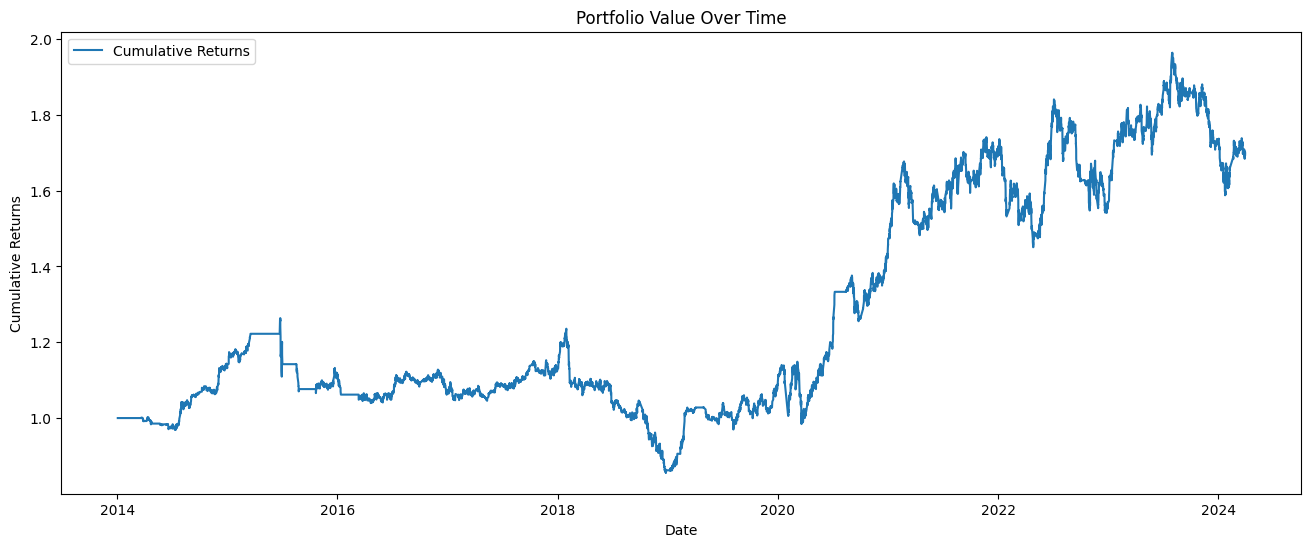

初始资金: 10000
最终资金: 17009.682099999995
年化收益率: 1.34%
最大回撤: -32.29%
夏普比率: 0.24


In [6]:
import numpy as np
import talib
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta

df = df_price.copy()

initial_capital = 10000
positions = 4  # 仓位数
slippage_and_fees = 0.00  # 滑点手续费
portfolio_value_tracker = []


capital = initial_capital
cash = initial_capital  
etf_value = 0
holdings = {etf: 0 for etf in df.columns} 
peak = {etf: 0 for etf in df.columns}


def check_buy_signals(etf, df, current_date, rsi_period=14, ma_period=200):
    if current_date < df.index[ma_period]:
        return False
    ma200 = df[etf].rolling(window=ma_period).mean()
    rsi = talib.RSI(df[etf].values, timeperiod=rsi_period)
    today_rsi = rsi[df.index.get_loc(current_date)]
    today_close = df.at[current_date, etf]
    yesterday_close = df.at[df.index[df.index.get_loc(current_date) - 1], etf]
    yesterday_ma200 = ma200[df.index.get_loc(current_date) - 1]

    if yesterday_close < yesterday_ma200 and today_close > ma200[current_date] and today_rsi < 70:
        return True
    return False


buy_dates = {etf: None for etf in df.columns}
buy_prices = {etf: 0 for etf in df.columns}
def buy(etf, price, date):
    global capital, cash, etf_value, holdings, stop_loss_price, take_profit_price
    if not np.isnan(price) and holdings[etf] == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        # 如果持有的ETF数量小于4，计算当前应该投入的资金
        if num_held_etfs < positions:
            # 仅使用现金计算可投资资金
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price)
            holdings[etf] = etf_amount
            cash -= etf_amount * price
            peak[etf] = price
            buy_dates[etf] = date
            buy_prices[etf] = price
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")


def sell(etf, price, date):
    global capital, cash, etf_value, holdings
    if not np.isnan(price) and holdings[etf] > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0


def check_stop_conditions(etf, price, date, buy_date, buy_price):
    global holdings, peak, stop_loss_price, take_profit_price
    if holdings[etf] <= 0 or buy_date is None:
        return False
    
    hours_held = (date - buy_date) / timedelta(hours=1)
    profit_percentage = (price - buy_price) / buy_price

    if (hours_held >= 200 and price < buy_price) or (profit_percentage > 0.15):
        return True

    return False


for date, prices in df.iterrows():
    for etf, price in prices.items():
        # 检查止损/止盈条件
        if buy_dates[etf] is not None and check_stop_conditions(etf, price, date, buy_dates[etf], buy_prices[etf]):
            sell(etf, price, date)
            buy_dates[etf] = None  # 重置买入日期
            buy_prices[etf] = 0  # 重置买入价格

    # 检查买入信号，如果满足条件则买入
    for etf in prices.index:
        if check_buy_signals(etf, df, date) and holdings[etf] == 0:
            num_held_etfs = sum(1 for h in holdings.values() if h > 0)
            if num_held_etfs < positions:
                buy(etf, prices[etf], date)
                buy_dates[etf] = date
                buy_prices[etf] = prices[etf]

    # 更新ETF市值和资金
    etf_value = sum(holdings[etf] * prices[etf] for etf in prices.index if holdings[etf] > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)
    
portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
std_dev = np.std(returns)
sharp_ratio = (average_daily_return / std_dev) * np.sqrt(252)

plt.figure(figsize=(16, 6))
plt.plot(df.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"夏普比率: {sharp_ratio:.2f}")

In [43]:
date_array = pd.to_datetime(df.index)
portfolio_series1 = pd.Series(data=portfolio_values, index=date_array)
portfolio_series1

datetime
2014-01-02 10:30:00    10000.0000
2014-01-02 11:30:00    10000.0000
2014-01-02 14:00:00    10000.0000
2014-01-02 15:00:00    10000.0000
2014-01-03 10:30:00    10000.0000
                          ...    
2024-03-28 15:00:00    26082.2147
2024-03-29 10:30:00    26131.9297
2024-03-29 11:30:00    26167.2867
2024-03-29 14:00:00    26072.4527
2024-03-29 15:00:00    26196.2897
Length: 9968, dtype: float64

In [44]:
portfolio_series_hourly_daily = portfolio_series1.resample('D').last()
len(portfolio_series_hourly_daily)

3740

In [45]:
portfolio_values = portfolio_series_hourly_daily

In [49]:
portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/2492)-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
std_dev = np.std(returns)
sharp_ratio = (average_daily_return / std_dev) * np.sqrt(252)

In [51]:
sharp_ratio

0.364223627165204

In [ ]:
def backtest(nv):
    # Compute the running max
    nv=nv/nv.iloc[0]
    running_max = np.maximum.accumulate(nv)
    running_max[nv < 1] = 1
    # Compute the drawdown
    drawdown = (nv/running_max - 1)
    max_drawdon = -drawdown.min()
    
    annual=(nv.iloc[-1]/nv.iloc[0])**(250/len(nv))-1
    log_returns = np.log(nv/nv.shift(1))
    volatility = log_returns.std() * np.sqrt(250)
    print('annual return:',annual)
    print('annual volatility:',volatility)
    print('DD:',max_drawdon)
    print('sharpe:',annual/volatility)

In [26]:
symbol = df_etf.order_book_id.values.tolist()
start = "2014-01-01"
end = "2024-03-31"
frequency = "1d"
df1 = get_price(symbol, start, end, frequency)[['open','high','low','close']]
df = df1.copy()
df['previous_close'] = df.groupby(level=0)['close'].shift(1)
df['tr0'] = df['high'] - df['low']
df['tr1'] = (df['high'] - df['previous_close']).abs()
df['tr2'] = (df['low'] - df['previous_close']).abs()
df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)
df_atr = df.groupby(level=0)['tr'].rolling(window=14).mean().droplevel(0)
df_atr = df_atr.unstack(level=0)
df_price = get_price(symbol, start, end, frequency)[['close']].unstack(level = 0)
df_price.columns = df_price.columns.droplevel(0)

2014-03-21 00:00:00: 买入 159928.XSHE, 价格 0.2375, 数量 10526
2014-03-28 00:00:00: 卖出 159928.XSHE, 价格 0.2282, 数量 10526
2014-04-08 00:00:00: 买入 159928.XSHE, 价格 0.2388, 数量 10366
2014-04-09 00:00:00: 买入 159930.XSHE, 价格 0.8079999999999999, 数量 3063
2014-04-21 00:00:00: 卖出 159930.XSHE, 价格 0.784, 数量 3063
2014-04-25 00:00:00: 卖出 159928.XSHE, 价格 0.2322, 数量 10366
2014-05-12 00:00:00: 买入 159930.XSHE, 价格 0.8029999999999999, 数量 3038
2014-05-15 00:00:00: 卖出 159930.XSHE, 价格 0.779, 数量 3038
2014-06-11 00:00:00: 买入 512010.XSHG, 价格 0.2125, 数量 11396
2014-06-16 00:00:00: 买入 159930.XSHE, 价格 0.7879999999999999, 数量 3073
2014-06-19 00:00:00: 卖出 159930.XSHE, 价格 0.764, 数量 3073
2014-06-19 00:00:00: 卖出 512010.XSHG, 价格 0.2065, 数量 11396
2014-06-25 00:00:00: 买入 159930.XSHE, 价格 0.78, 数量 3059
2014-06-27 00:00:00: 买入 512010.XSHG, 价格 0.212, 数量 11256
2014-07-02 00:00:00: 买入 159928.XSHE, 价格 0.2288, 数量 10430
2014-07-09 00:00:00: 卖出 512010.XSHG, 价格 0.2078, 数量 11256
2014-07-15 00:00:00: 买入 512010.XSHG, 价格 0.2118, 数量 11155
2014-09-

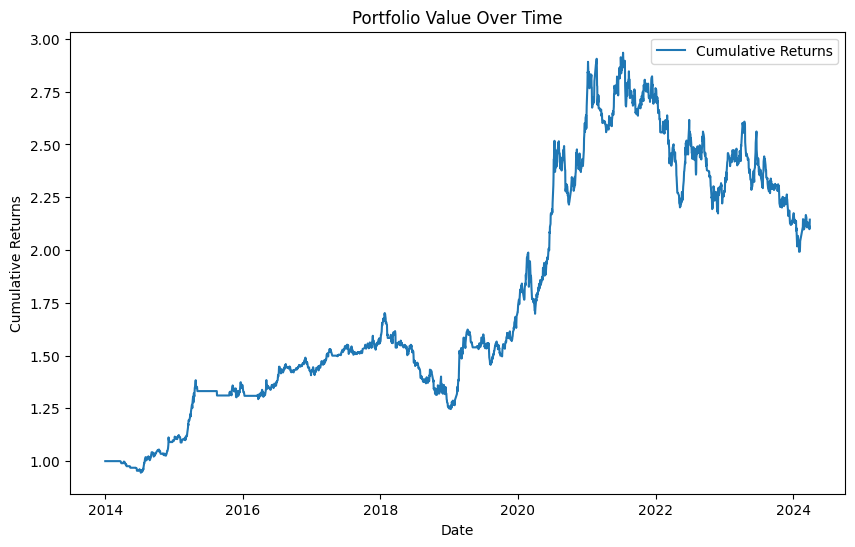

初始资金: 10000
最终资金: 21437.440699999996
年化收益率: 7.95%
最大回撤: -32.13%
夏普比率: 0.61


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = df_price.copy()

initial_capital = 10000
positions = 4  # 仓位数
slippage_and_fees = 0.00  # 滑点手续费
portfolio_value_tracker = []


capital = initial_capital
cash = initial_capital  
etf_value = 0
holdings = {etf: 0 for etf in df.columns} 
peak = {etf: 0 for etf in df.columns}
stop_loss_price = {etf: 0 for etf in df.columns}  # 止损价
take_profit_price = {etf: 0 for etf in df.columns}  # 止盈价

def check_buy_signals(etf, df, current_date):
    if current_date < df.index[50]:
        return False
    ma10 = df[etf].rolling(window=50).mean()
    today_close = df.at[current_date, etf]
    yesterday_close = df.at[df.index[df.index.get_loc(current_date) - 1], etf]
    yesterday_ma10 = ma10[df.index.get_loc(current_date) - 1]

    if yesterday_close < yesterday_ma10 and today_close > ma10[current_date]:
        return True
    return False

def buy(etf, price, date, atr):
    global capital, cash, etf_value, holdings, stop_loss_price, take_profit_price
    if not np.isnan(price) and holdings[etf] == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        # 如果持有的ETF数量小于4，计算当前应该投入的资金
        if num_held_etfs < positions:
            # 仅使用现金计算可投资资金
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price)
            holdings[etf] = etf_amount
            cash -= etf_amount * price
            peak[etf] = price
            # 设置初始的止盈价和止损价
            stop_loss_price[etf] = price - 1.5 * atr
            take_profit_price[etf] = price + 3 * atr
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")


def sell(etf, price, date):
    global capital, cash, etf_value, holdings
    if not np.isnan(price) and holdings[etf] > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0


def check_stop_conditions(etf, price, atr):
    global holdings, peak, stop_loss_price, take_profit_price
    if holdings[etf] <= 0:
        return False
    if price > take_profit_price[etf]:
        take_profit_price[etf] = price + 3 * atr
        stop_loss_price[etf] = price - 1.5 * atr
        peak[etf] = price  # 更新峰值价格
    if price <= stop_loss_price[etf]:
        return True
    return False


start_date = df.index[0]
for date, prices in df.iterrows():
    atr_values = df_atr.loc[date]  # 获取当天的ATR值
    for etf, price in prices.items():
        if check_stop_conditions(etf, price, atr_values[etf]):
            sell(etf, price, date)

    # 检查买入信号，如果满足条件则买入
    for etf in prices.index:
        if check_buy_signals(etf, df, date):
            num_held_etfs = sum(1 for h in holdings.values() if h > 0)
            if num_held_etfs < positions:
                atr = atr_values[etf]
                buy(etf, prices[etf], date, atr)

    # 更新ETF市值和资金
    etf_value = sum(holdings[etf] * prices[etf] for etf in prices.index if holdings[etf] > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)
    
portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
std_dev = np.std(returns)
sharp_ratio = (average_daily_return / std_dev) * np.sqrt(252)

plt.figure(figsize=(10, 6))
plt.plot(df.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"夏普比率: {sharp_ratio:.2f}")

In [28]:
date_array = pd.to_datetime(df.index)
portfolio_series2 = pd.Series(data=portfolio_values, index=date_array)
portfolio_series2

date
2014-01-02    10000.0000
2014-01-03    10000.0000
2014-01-06    10000.0000
2014-01-07    10000.0000
2014-01-08    10000.0000
                 ...    
2024-03-25    21156.0277
2024-03-26    21146.1357
2024-03-27    20985.3447
2024-03-28    21094.8387
2024-03-29    21437.4407
Length: 2492, dtype: float64

In [37]:
import pandas as pd

portfolio_series_hourly_daily.index = pd.to_datetime(portfolio_series_hourly_daily.index)
portfolio_series2.index = pd.to_datetime(portfolio_series2.index)
daily_series = pd.Series(data=portfolio_series2.values, index=portfolio_series2.index, name='Daily')
portfolio_series_hourly_daily = pd.Series(data=portfolio_series_hourly_daily.values, index=portfolio_series_hourly_daily.index, name='Hourly')
merged_df = pd.merge(daily_series, portfolio_series_hourly_daily, left_index=True, right_index=True, how='inner')

correlation = merged_df['Daily'].corr(merged_df['Hourly'])
correlation

0.9150042623095742

In [35]:
portfolio_series_hourly_daily.values

array([10000.    , 10000.    ,        nan, ..., 26020.8227, 26082.2147,
       26196.2897])

In [ ]:
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1